In [1]:
import sys
print(sys.executable)

c:\Users\jlian\Projects\DiAGE\nn\venv_DiAge\Scripts\python.exe


In [2]:
import numpy as np 
import pandas as pd
import math
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from captum.attr import FeaturePermutation

c:\Users\jlian\Projects\DiAGE\nn\venv_DiAge\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set device to gpu if you have one 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce RTX 2060 with Max-Q Design


In [4]:
df = pd.read_csv('../ProcessedData/SRR_AllGex_Normal.csv')
df.head(5)

,Sample_run,LoadDate,spots,bases,avgLength,size_MB,Experiment,LibraryStrategy,LibraryLayout,Platform,...,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx,NA
0,SRR023543,2014-05-26,16527580.0,2.512192e+09,152,1675,SRX008012,EST,PAIRED,ILLUMINA,...,1.20130,12.6978,1.18467,129.60060,9.74589,2.20648,11.030954,5.738700,9.341037,SRR023543
1,SRR023547,2014-05-26,3950696.0,6.005058e+08,152,386,SRX008024,EST,PAIRED,ILLUMINA,...,155.51900,34.3344,15.55430,43.81180,71.99370,24.41320,45.028855,0.164853,13.134690,SRR023547
2,SRR023548,2014-05-26,5163512.0,7.848538e+08,152,508,SRX008022,EST,PAIRED,ILLUMINA,...,137.28700,37.6628,17.24720,45.70918,75.53160,20.96860,40.057021,0.234581,10.762830,SRR023548
3,SRR023550,2014-05-26,624074.0,9.485925e+07,152,51,SRX008021,EST,PAIRED,ILLUMINA,...,0.00000,10.7049,0.00000,142.79590,14.94060,4.35217,26.939000,1.292820,7.458770,SRR023550
4,SRR023595,2014-05-26,16268792.0,2.472856e+09,152,1612,SRX008013,EST,PAIRED,ILLUMINA,...,71.61989,28.9123,12.40980,84.67824,36.22180,7.45907,22.298477,8.497140,4.924637,SRR023595


In [5]:
# drop unrelated columns 
drop_list = ['Sample_run', 'LoadDate', 'spots', 'bases', 'avgLength', 'size_MB', 'Experiment', 'LibraryStrategy', 'LibraryLayout', 'Platform', 'SRAStudy', 'BioProject', 'Sample', 'BioSample', 'Notes', 'GSM', 'NA']
df.drop(drop_list, axis=1, inplace=True)
df

,Age,Sex,Tissue,128up,14-3-3epsilon,14-3-3zeta,140up,18w,26-29-p,2mit,...,zormin,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx
0,1.0,Male,WholeBody,31.1145,269.40680,392.263524,8.400255,14.01000,116.0030,2.421153,...,48.046240,1.201300,12.69780,1.184670,129.60060,9.74589,2.206480,11.030954,5.738700,9.341037
1,5.0,Female,WholeBody,104.8230,739.90070,437.565162,18.037600,8.19364,790.4050,0.360670,...,9.928468,155.519000,34.33440,15.554300,43.81180,71.99370,24.413200,45.028855,0.164853,13.134690
2,30.0,Female,WholeBody,107.4420,699.27340,404.701470,18.628811,9.00279,743.1840,0.421805,...,8.926325,137.287000,37.66280,17.247200,45.70918,75.53160,20.968600,40.057021,0.234581,10.762830
3,5.0,Male,WholeBody,20.0598,310.96850,343.131800,0.000000,5.92016,113.7670,1.014380,...,48.146530,0.000000,10.70490,0.000000,142.79590,14.94060,4.352170,26.939000,1.292820,7.458770
4,1.0,Female,WholeBody,78.3015,485.00018,359.507949,8.823970,13.04500,497.5650,0.954807,...,32.326160,71.619890,28.91230,12.409800,84.67824,36.22180,7.459070,22.298477,8.497140,4.924637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,30.0,Female,Thorax,20.4836,85.57011,282.407457,11.274624,38.02110,83.4241,1.265131,...,35.129550,0.570598,9.17905,0.153134,15.79412,9.13991,0.693815,10.433380,0.466425,45.648136
483,30.0,Female,Thorax,15.1945,77.55480,240.957858,8.174643,31.91630,71.6350,1.011920,...,28.217040,0.346105,9.83452,0.092886,10.20381,7.88394,0.589182,8.312930,0.934856,52.559250
484,30.0,Female,Thorax,21.7758,89.82335,281.918100,9.493170,36.78680,72.2978,1.240900,...,32.987120,1.144910,11.50130,0.279330,13.91044,9.90580,0.759350,9.158343,0.314427,39.675950
485,50.0,Female,Thorax,26.1045,120.57710,380.987174,11.767630,43.23620,95.9376,1.244600,...,40.403000,0.323113,15.05910,0.000000,17.51082,12.32300,0.458369,11.940874,1.263200,52.174420


In [6]:
# one-hot encoding for sex and tissue
index = df.columns.get_loc('Sex')
encoded = pd.get_dummies(df['Sex'], prefix='Sex')
df = df.drop('Sex', axis=1)
for i, col in enumerate(encoded.columns):
    df.insert(index + i, col, encoded[col])

index = df.columns.get_loc('Tissue')
encoded = pd.get_dummies(df['Tissue'], prefix='Tissue')
df = df.drop('Tissue', axis=1)
for i, col in enumerate(encoded.columns):
    df.insert(index + i, col, encoded[col])

df

,Age,Sex_Female,Sex_Male,Sex_Unknown,Sex_mixed,Tissue_Bodies,Tissue_Brain,Tissue_Brains,Tissue_Head,Tissue_Heads,...,zormin,zpg,Zpr1,zuc,Zw,Zw10,Zwilch,zyd,zye,Zyx
0,1.0,False,True,False,False,False,False,False,False,False,...,48.046240,1.201300,12.69780,1.184670,129.60060,9.74589,2.206480,11.030954,5.738700,9.341037
1,5.0,True,False,False,False,False,False,False,False,False,...,9.928468,155.519000,34.33440,15.554300,43.81180,71.99370,24.413200,45.028855,0.164853,13.134690
2,30.0,True,False,False,False,False,False,False,False,False,...,8.926325,137.287000,37.66280,17.247200,45.70918,75.53160,20.968600,40.057021,0.234581,10.762830
3,5.0,False,True,False,False,False,False,False,False,False,...,48.146530,0.000000,10.70490,0.000000,142.79590,14.94060,4.352170,26.939000,1.292820,7.458770
4,1.0,True,False,False,False,False,False,False,False,False,...,32.326160,71.619890,28.91230,12.409800,84.67824,36.22180,7.459070,22.298477,8.497140,4.924637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,30.0,True,False,False,False,False,False,False,False,False,...,35.129550,0.570598,9.17905,0.153134,15.79412,9.13991,0.693815,10.433380,0.466425,45.648136
483,30.0,True,False,False,False,False,False,False,False,False,...,28.217040,0.346105,9.83452,0.092886,10.20381,7.88394,0.589182,8.312930,0.934856,52.559250
484,30.0,True,False,False,False,False,False,False,False,False,...,32.987120,1.144910,11.50130,0.279330,13.91044,9.90580,0.759350,9.158343,0.314427,39.675950
485,50.0,True,False,False,False,False,False,False,False,False,...,40.403000,0.323113,15.05910,0.000000,17.51082,12.32300,0.458369,11.940874,1.263200,52.174420


In [7]:
print(df.dtypes.value_counts())

float64    13666
bool          11
Name: count, dtype: int64


In [8]:
class Data(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [36]:
# split data into training and validation, scale data
X = df.drop(columns=['Age'])
y = df['Age']

X = X.astype('float64') # when not using standard scaler
# X = X.apply(lambda x: x / x.max(), axis=0) # fraction of max

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)
print(X_train)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_valid_scaled = scaler.transform(X_valid)

# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
# X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32)
# y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)

# testing no scaling
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)


train_data = Data(X_train_tensor, y_train_tensor)
valid_data = Data(X_valid_tensor, y_valid_tensor)

batch_size = 32

train_loader = DataLoader(train_data, batch_size)
valid_loader = DataLoader(valid_data, batch_size)


     Sex_Female  Sex_Male  Sex_Unknown  Sex_mixed  Tissue_Bodies  \
415         0.0       1.0          0.0        0.0            0.0   
314         0.0       1.0          0.0        0.0            0.0   
25          1.0       0.0          0.0        0.0            0.0   
222         1.0       0.0          0.0        0.0            0.0   
298         1.0       0.0          0.0        0.0            0.0   
..          ...       ...          ...        ...            ...   
106         0.0       0.0          1.0        0.0            0.0   
270         1.0       0.0          0.0        0.0            0.0   
348         0.0       1.0          0.0        0.0            0.0   
435         1.0       0.0          0.0        0.0            1.0   
102         0.0       0.0          1.0        0.0            0.0   

     Tissue_Brain  Tissue_Brains  Tissue_Head  Tissue_Heads  Tissue_Thorax  \
415           0.0            0.0          0.0           1.0            0.0   
314           1.0          

C:\Users\jlian\AppData\Local\Temp\ipykernel_31248\957607681.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
C:\Users\jlian\AppData\Local\Temp\ipykernel_31248\957607681.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.targets = torch.tensor(targets, dtype=torch.float32)


In [10]:
batch = next(iter(train_loader))
batch[0].shape

torch.Size([32, 13676])

In [11]:
model = nn.Sequential(
    nn.Linear(13676, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8,1)
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.00005)

In [12]:
epochs = 500
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):

        # forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        running_loss += loss.item()

    if not ((epoch + 1) % (epochs // 100)):
        print(f'Epochs:{epoch + 1:5d} | ' \
        f'Batches per epoch: {i + 1:3d} | ' \
        f'Loss: {running_loss / (i + 1):.10f}')

Epochs:    5 | Batches per epoch:  13 | Loss: 551.9059800368
Epochs:   10 | Batches per epoch:  13 | Loss: 337.7521960919
Epochs:   15 | Batches per epoch:  13 | Loss: 257.2528522198
Epochs:   20 | Batches per epoch:  13 | Loss: 244.2824202317
Epochs:   25 | Batches per epoch:  13 | Loss: 233.1879172692
Epochs:   30 | Batches per epoch:  13 | Loss: 222.2865940974
Epochs:   35 | Batches per epoch:  13 | Loss: 210.6466886080
Epochs:   40 | Batches per epoch:  13 | Loss: 197.6089659471
Epochs:   45 | Batches per epoch:  13 | Loss: 182.7201109666
Epochs:   50 | Batches per epoch:  13 | Loss: 165.5162893442
Epochs:   55 | Batches per epoch:  13 | Loss: 145.9249484722
Epochs:   60 | Batches per epoch:  13 | Loss: 124.8138257540
Epochs:   65 | Batches per epoch:  13 | Loss: 103.4994923518
Epochs:   70 | Batches per epoch:  13 | Loss: 83.1171681331
Epochs:   75 | Batches per epoch:  13 | Loss: 65.0163967426
Epochs:   80 | Batches per epoch:  13 | Loss: 50.3132042518
Epochs:   85 | Batches per 

MSE Loss: 5.85283
RMSE Loss: 2.419261580587431


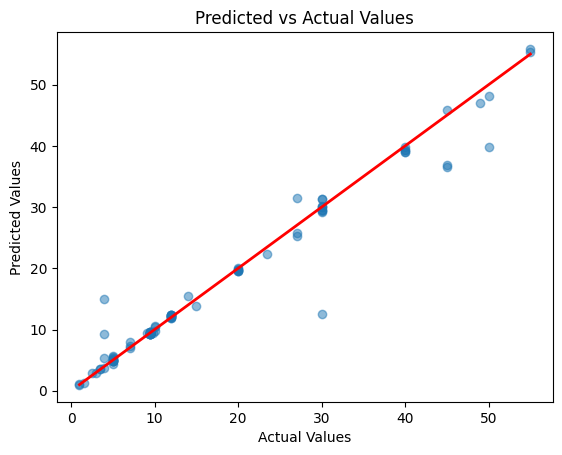

In [37]:
# validate with test data

import matplotlib.pyplot as plt

y_true = []
y_pred = []

RMSE = 0

with torch.no_grad():
    loss = 0
    for i, (inputs, labels) in enumerate(valid_loader):
        predictions = model(inputs)
        y_pred.extend(predictions.squeeze().numpy())
        y_true.extend(labels.squeeze().numpy())
        loss += F.mse_loss(predictions, labels)
    print(f'MSE Loss: {loss / (i + 1):.5f}')
    print(f'RMSE Loss: {math.sqrt(loss / (i + 1))}')
    RMSE = math.sqrt(loss / (i + 1))

# Assuming `y_true` is the actual target values and `y_pred` is the predicted values
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', lw=2)  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [14]:
now = datetime.now()
model_name = f'{str(round(RMSE, 2))} {now.strftime("%Y-%m-%d %H_%M")}' 
print(model_name)
torch.save(model.state_dict(), f'models/{model_name}.pt')



3.4 2024-10-23 17_08


In [34]:
model = nn.Sequential(
    nn.Linear(13676, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8,1)
)
model.load_state_dict(torch.load('models/2.42 2024-10-23 16_51.pt', weights_only=True))
model.eval()

Sequential(
  (0): Linear(in_features=13676, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=32, bias=True)
  (9): ReLU()
  (10): Linear(in_features=32, out_features=16, bias=True)
  (11): ReLU()
  (12): Linear(in_features=16, out_features=8, bias=True)
  (13): ReLU()
  (14): Linear(in_features=8, out_features=1, bias=True)
)

In [38]:
# def get_RMSE():
#     with torch.no_grad():
#         loss = 0
#         for i, (inputs, labels) in enumerate(valid_loader):
#             predictions = model(inputs)
#             loss += F.mse_loss(predictions, labels)
#         return math.sqrt(loss / (i + 1))
def forward(inputs):
    return model(inputs)
        
feature_perm = FeaturePermutation(forward)
attributions = feature_perm.attribute(X_valid_tensor, target=0, show_progress=True)
feature_importance = torch.mean(torch.abs(attributions), dim=0)

Feature Permutation attribution: 100%|██████████| 13677/13677 [04:42<00:00, 48.44it/s]


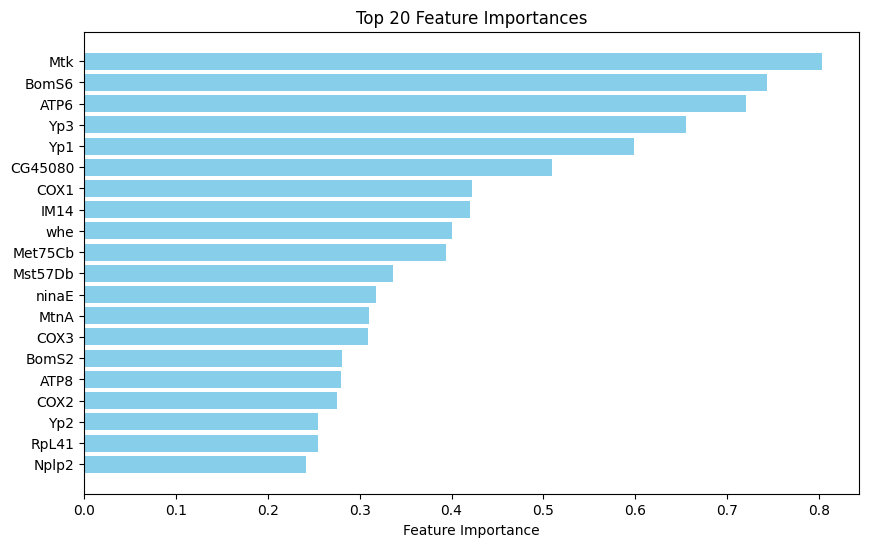

In [39]:
features = list(X.columns.values)
sorted_indices = np.argsort(feature_importance).tolist()
sorted_indices.reverse()
top_20_indices = sorted_indices[:20]
features_top20 = [features[i] for i in top_20_indices]
feature_importance_top20 = [feature_importance[i] for i in top_20_indices]

# Create a bar plot for the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(features_top20, feature_importance_top20, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis so the top feature is at the top
plt.show()

In [41]:
features.index('mah')
feature_importance[features.index('mah')]

tensor(0.0007)